# Feature Selection

In the notebook "Data Preprocessing" I have cleaned up the data of missing values, dropped columns that had a large amount of missing values, and also created some features for the non-normally distributed categorical columns by grouping the most frequently occuring class into a new group and the rest into a set of smaller groups.

After this process I am left with 243 columns. I am now going to try to select a smaller subset of these features.

In [610]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df_cleaned = pd.read_csv('../data/cleaned_datasets/df_cleaned_draft1.csv')

In [611]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44461 entries, 0 to 44460
Columns: 244 entries, Var6 to target
dtypes: float64(243), int64(1)
memory usage: 82.8 MB


The first technique I am going to use is variable ranking. This is a process whereby you rank each feature according to some scoring metric S(feature), and then select the k top scoring variables to use in classification.

This is a class of feature selection methods called **filter methods**. 

Another class of feature selection is called **embedded methods** whereby the subset selection is implicitly performed by the classification model itself. The two most common embedded methods of feature selection are lasso and ridge regression. 

A third class of subset selection is **wrapper methods**. In wrapper methods, similar to embedded methods, the model being trained is used to select the subset. However, in wrapper methods, the model's performance being trained is used to decide if more or less features should be included. Examples of this are forward and backward subset selection. These are generally vry expensive as a lot of models have to be trained to determine which feature should next be included/excluded. With 243 features I do not want to use wrapper methods.

***
## Variable Ranking

I am going to use Pearson's correlation as my ranking metric. I will make a list the column names going from most correlated to least correlated. Then later with the models I train the data on I can use cross-validation with differing numbers of fetaures to select the best subset of features

In [612]:
df_cleaned.head()

,Var6,Var7,Var13,Var22,Var24,Var25,Var28,Var35,Var38,Var44,...,x19_4,x19_5,x19_6,x19_7,x19_8,x19_9,x20_False,x20_True,Var225_encode,target
0,0.011582,0.05,0.000930,0.012792,0.028340,0.009721,0.044674,0.0,0.000189,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1
1,0.003984,0.00,0.000000,0.004632,0.004049,0.001823,0.080453,0.0,0.252825,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
2,0.039739,0.05,0.004569,0.033414,0.052632,0.061968,0.054916,0.0,0.312194,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1
3,0.006535,0.00,0.000000,0.000000,0.004049,0.000000,0.017024,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1
4,0.007810,0.05,0.016253,0.001764,0.008097,0.004860,0.051073,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1


First thing to notice is that 'x17_False' is NaN because it contains one single value (0). It must have been highly correlated with a column that was dropped in the preprocessing.

Also, no feature has a correlation score more than 0.1. With 243 features this is not all that surprising. This doesn't mean that there is no predictive power in the data though.

In [613]:
ranked_features = np.abs(df_cleaned.corr()['target']).sort_values()[::-1]

ranked_features

x17_False                       NaN
target                     1.000000
Var73                      0.089297
x9_Missing                 0.087638
x20_True                   0.082246
                             ...   
x13_3Cy4                   0.000216
x12_LM8l689qOp             0.000213
Var123                     0.000172
x13_453m                   0.000116
x15_0pzBWGkV3fbsGZN52DH    0.000101
Name: target, Length: 244, dtype: float64

In [614]:
df_cleaned['x17_False'].value_counts()

0.0    44461
Name: x17_False, dtype: int64

In [616]:
ranked_feature_names = ranked_features.index
ranked_feature_names = ranked_feature_names.drop(['x17_False', 'target'], errors='ignore')
ranked_feature_names

Index(['Var73', 'x9_Missing', 'x20_True', 'x20_False', 'Var189',
       'x15_F2FyR07IdsN7I', 'x3_sJzTlal', 'Var7', 'x5_me75fM6ugJ', 'x14_RAYp',
       ...
       'x13_xb3V', 'Var181', 'Var83', 'x5_GjJ35utlTa_GNSvxxpb9ju', 'x4_sYC_',
       'x13_3Cy4', 'x12_LM8l689qOp', 'Var123', 'x13_453m',
       'x15_0pzBWGkV3fbsGZN52DH'],
      dtype='object', length=242)

***
# Imbalanced Classes
The other thing I need to deal with before performing any classifications is the imbalance of the two target variables.

Over 90% of the observations belong to class -1 which I guess is customers who did not churn. So we do not have many occurances of observations where customers did churn.

There are various ways to deal with imbalanced data. The simpliest is over- or under sampling the data. With only a few tens of thousands of datapoints it is probably best to oversample the minority class.

Another method, which requires no work at this stage is to carefully consider what performance metric I use. In this case of imbalanced classes, using accuracy would be dangerous as the null model that just classifies all customers to the majority class will achieve an accuracy of 90%. Instead using ROC curves, and more specifically the area under the curve (AUC) would allow us to see the performance of a model over the full range of threshold values.

I will try both of these methods. So here I generate a new over-sampled dataset.

(array([41081.,  3380.]), array([-1.,  0.,  1.]), <a list of 2 Patch objects>)

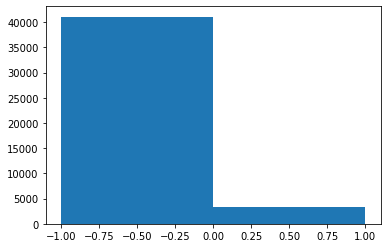

In [617]:
plt.hist(df_cleaned['target'], bins=2)

In [7]:
41081/(41081+3380)

0.9239783180765165

In [656]:
X_cleaned = df_cleaned.drop(['target', 'x17_False'], axis=1)
y_cleaned = df_cleaned['target']


Create training and test sets and then oversample the training sets

In [657]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.33)

ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

y_resampled.value_counts()

-1    41081
 1    41081
Name: target, dtype: int64

Now standardizw both the original data and the resampled data according to the training datasets

In [664]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

scaler.fit(X_train_resampled)
X_train_resampled = pd.DataFrame(data=scaler.transform(X_train_resampled), columns=X_train_resampled.columns)

***
# Metrics
This is a note on metrics for classification.

### accuracy
$accuracy = \frac{TP + TN}{TP + TN+ FN + FP}$ = what fraction of the examples did the model correctly classify. This is global, i.e. calculated across all classes.

### precision
$precision = \frac{TP}{TP + FP}$ = what fraction of the examples that the model classified as true are actually true. This is class specific.

### recall (sensitivity)
$recall = \frac{TP}{TP + FN} =  \frac{TP}{N_p}$ = what fraction of the examples that are actually true did that model classify as true. This is class specific.

### sensitivity (positive prediction power)
sensitivity = $\frac{TP}{TP + FN} = \frac{TP}{N_p}$ same as above, the fraction of correctly identified positive cases out of all positive cases $N_p$.

### specificity (negative prediction power)
specificity = $\frac{TN}{TN + FP} = \frac{TN}{N_n}$ the negative class counterpart to sensitivity, the fraction of correctly identified negative cases out of all negative cases $N_n$.

### true positive rate
TPR = $\frac{TP}{TP + FN} = \frac{TP}{N_p}$ = as the name suggests, the rate at which a TP is predicted for each positive class actually present, $N_p$. For example, if TPR = 0.5, that means for every 2 positive classes in the dataset, the model will correctly predict 1 of them.

### false positive rate
FPR = $\frac{FP}{FP + TN} = \frac{FP}{N_n}$ = as the name suggests, the rate at which a FP is predicted for each negative class actually present, $N_n$. For example, if FPR = 0.3, that means for every 3 negative classes in the dataset, the model will correctly predict 1 of them as positive.

### F1
Is defined as the *weighted-harmonic mean of the precision and recall*
$F1 = 2\frac{precision \times recall}{precision + recall}$ = a measure of the accuracy of the model

The F score reaches the best value, meaning perfect precision and recall, at a value of 1. The worst F score, which means lowest precision and lowest recall, would be a value of 0. 

The F score is used to measure a test’s accuracy, and it balances the use of precision and recall to do it. The F score can provide a more realistic measure of a test’s performance by using both precision and recall.

### suppport
is the # of occurances of each class in y_true.

In other words, if 'class 1' in y_true occured 3000 times, the support is 3000 for that class.

classification_report also publishes 'macro' and 'weighted' version of the metrics above. My understanding is,

### macro
macro avg. = Calculate metrics for each label, and find their *unweighted* mean. 

This does not take label imbalance into account. So it just sums the class specific metrics and divides by the number of classes. For instance if there is i classes and we wanted the 'macro' average of precision

macro avg. precision = $\frac{\sum_i precision_i}{i}$

### weighted
weighted avg. = Calculate metrics for each label, and find their mean *weighted by support* (the number of true instances for each label). 

This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall. For instance, if there is i classes and we wanted the 'weighted' average of precision

weighted avg. precision = $\frac{\sum_i precision_i*support_i}{\sum support_i} = \frac{\sum_i precision_i*support_i}{N_{tot}}$
where N_tot is the total number of examples.
***
## Which metric?
So which metric should we be optimising here? From some reading around there seems to be two common AUC metrics that are used to compare models across a the full range of threshold values so that you can say one model is generally better than another:
1. AUC ROC curve which is a plot of TPR against FPR
2. AUC of the plot of precision against recall

As stated in [[1]](http://www.blogspot.udec.ugto.saedsayad.com/docs/ROC101.pdf)

"*If the proportion of positive to negative instances changes in a test set, the ROC curves will not change. Metrics such as accuracy, precision, lift and F scores use values from both columns of the confusion matrix. As a class distribution changes these measures will change as well, even if the fundamental classifier performance does not. ROC graphs are based upon TP rate and FP rate, in which each dimension is a strict columnar ratio, so do not depend on class distributions.*"

which they portray as an advantage of using ROC curves. They show this insensitivity to class ratio changes with the following plot

<img src="../images/ROC_precision_recall_curves.png" width = 500 />

It shows how when the class imbalance is changed from 1:1 for the top two plots to 10:1 the ROC curve remains the same whereas the precision-recall curve changes drastically even though the classifier has not changed.

In contrast in [[2]](https://www.biostat.wisc.edu/~page/rocpr.pdf) the authors make the point that "*algorithms that optimize the area under the ROC curve are not guaranteed to optimize the area under the PR curve*". In contrast to above they don't see the insensitivity of ROC curves as an advantage like the previous author does.

However, from checking the competition report from the [KDD CUP 2009](http://www.vincentlemaire-labs.fr/publis/jmlrwcp_2009_camera_ready.pdf) they use the ROC AUC to compare competition submissions. Because of this I will use ROC too so I can directly compare with what results they state in the write up. From the report,

"*The participants were asked to provide a score (a discriminant value or a posterior probability P(Y = 1|X)), and they were judged by the area under the ROC curve (AUC). The AUC is the area under the curve plotting sensitivity vs. (1− specificity) when the threshold θ is varied (or equivalently the area under the curve plotting sensitivity vs. specificity). We call “sensitivity” the error rate of the positive class and “specificity” the error rate
of the negative class. The AUC is a standard metric in classification*"

***
***
# Logistic Regression

## Base performance
Okay, I now have a list of the most correlated variables that I can use. First let's perform logistic regression with all features included to set some kind of baseline performance.

To get this LogisticRegression model to fit without any penalisation I had to increase the 'tol' value. This controls the level at which the logistic regression model will stop trying to fit the data. The higher the value, the less accurately the model has to fit to be deemed acceptable and stop fitting.

I am also using CV with 5 splits and using AUC as my evaluation metric.

In [668]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, auc, plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from scipy import interp

In [671]:
lr = LogisticRegression(penalty='none', max_iter=200, solver='newton-cg', tol=5e-3)
cv = StratifiedKFold(n_splits=5)

The graph below plots the ROC curve for the 5 folds generated as well as the mean ROC curve and associated AUC values. In grey is shown the standard deviation of the 5 CV ROC curves.

The AUC is very stable amongst the training set splits which is good news and gives me a value of 0.67. 
The graph shows that this base model is better than random with an AUC score of 0.67.

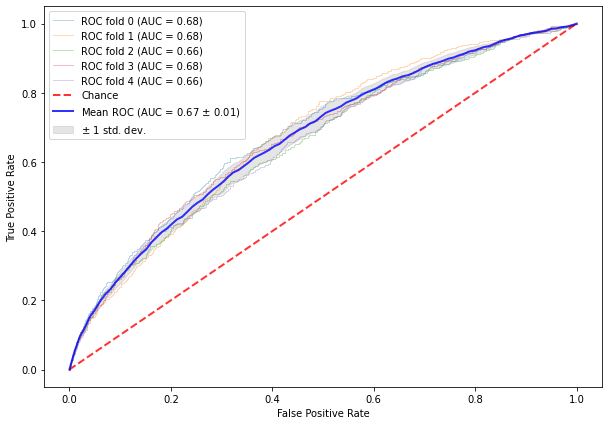

In [676]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,7))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    lr.fit(X_train.iloc[train], y_train.iloc[train])
    viz = plot_roc_curve(lr, X_train.iloc[test], y_train.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.legend()

In [678]:
AUC_dict = dict()
AUC_dict['LR base'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019}

## L1 Regularisation

L1 regularisation is actually a form of feature selection as it shrinks some coefficients down to zero, where as L2 regularisation only shrinks coefficient towards zero asymptotically. Let's see if using L1 regularisation helps.

In [336]:
lr_l1 = LogisticRegression(penalty='l1', max_iter=200, solver='liblinear')

Adding L1 regularisation has not helped much. From the count below I can see that as expected the L1 regularisation has reduced the coefficient of many of the features to 0. Out of 243 features there is only 209 non-zero coefficient from the logistic regression fit. However the AUC is still 0.68.

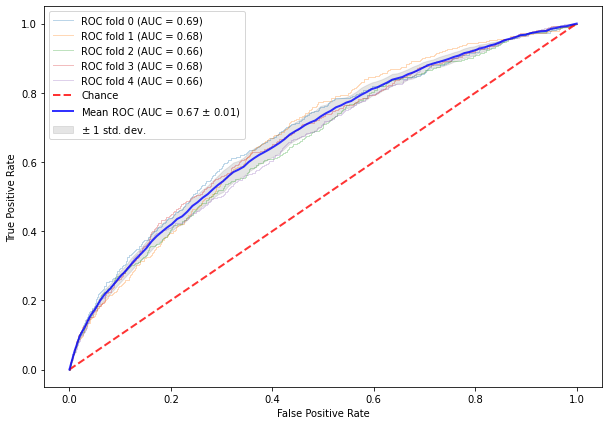

In [679]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,7))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    lr_l1.fit(X_train.iloc[train], y_train.iloc[train])
    viz = plot_roc_curve(lr_l1, X_train.iloc[test], y_train.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.legend()

In [681]:
AUC_dict['LR + L1'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019, 'LR + L1': 0.6725085508655976}

In [682]:
np.count_nonzero(lr_l1.coef_[0])

209

## L1 Regularisation + Balanced Classes
Now I am going to try to give the model a better chance at correctly identifying churners. It may be that in the previous two models there simply isnt enough examples of churners so let's try using over-sampled datasets. 

I have to be careful about when to over-sample the data. If I use the resampled dataset I created earlier with CV, the upsampled data will get split into K folds. The fold held out for validation will almost certainly contain observations that were used in the training folds and so this is not a good measure of test set AUC. This is especially true of this dataset which contains only 7% of the positive class so the resampling contains around 10 replicas of each positive observation. Because of this, I split the data into K folds, then within each fold I over-sample the training fold, and leave the validation fold alone so that it contains observations that are not in the training fold.

In [683]:
lr_l1_bal = LogisticRegression(penalty='l1', max_iter=200, solver='liblinear')

Doesn't seem like the balancing of classes has helped as the AUC is still 0.68

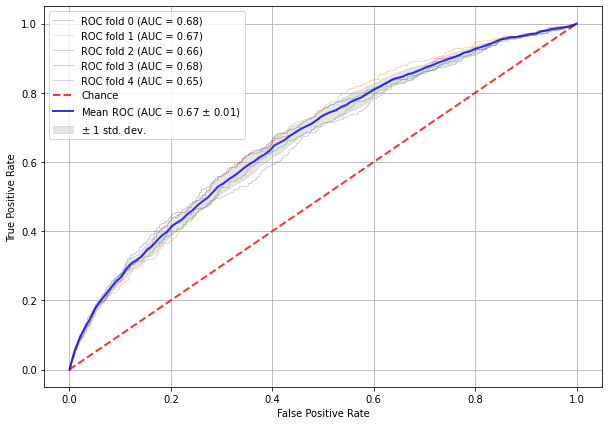

In [745]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

ros = RandomOverSampler()    
    
fig, ax = plt.subplots(figsize=(10,7))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    
    # Get training fold
    X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
    
    # Get validation fold
    X_val_fold, y_val_fold = X_train.iloc[test], y_train.iloc[test]
    
    # Over-sample data from training fold
    X_train_fold_resample, y_train_fold_resample = ros.fit_resample(X_train_fold, y_train_fold)
    
    # Fit model using the resampled training fold
    lr_l1_bal.fit(X_train_fold_resample, y_train_fold_resample)
    # Evaluate AUC using non-sampled validation fold
    viz = plot_roc_curve(lr_l1_bal, X_val_fold, y_val_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.legend()
plt.grid(which='both')
plt.show()

In [746]:
AUC_dict['LR + L1 + balanced'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019,
 'LR + L1': 0.6725085508655976,
 'LR + L1 + balanced': 0.6691666746294899,
 'LR + L1 + balanced + top 50 ranking': 0.686717722681359,
 'LR + L2 + balanced + RFE subset': 0.7034887052341596,
 'LR + L2 + balanced + adaboost ensemble': 0.7020315886134068,
 'DT base': 0.5334932559175184,
 'DT + balanced + adaboosted ensemble': 0.7120336217986788}

Make the plot and return mean_auc a function for re-use

In [831]:
def score_and_plot_model(model, X_train, y_train, balance=False):
    from sklearn.metrics import roc_auc_score, auc, plot_roc_curve
    from scipy import interp
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    ros = RandomOverSampler()    

    fig, ax = plt.subplots(figsize=(10,7))
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        
        

        # Get training fold
        X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]

        # Get validation fold
        X_val_fold, y_val_fold = X_train.iloc[test], y_train.iloc[test]
        
        # balance training data if balance=True
        if balance:
             # Over-sample data from training fold
            X_train_fold, y_train_fold = ros.fit_resample(X_train_fold, y_train_fold)
            
            
            

        # Fit model using the resampled training fold
        model.fit(X_train_fold, y_train_fold)
        # Evaluate AUC using non-sampled validation fold
        viz = plot_roc_curve(model, X_val_fold, y_val_fold,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.legend()
    plt.grid(which='both')
    plt.show()
    
    return mean_auc, viz

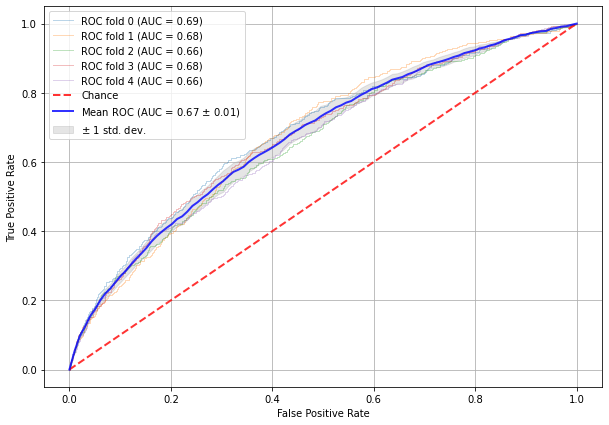

In [827]:
auc = score_and_plot_model(lr_l1_bal, X_train, y_train, balance=False)

## L1 Regularisation + Variable Ranking
Now I am going to try using only the top 50 features as determined by my varibale ranking section from earlier. I'll also fit a logistic regression model with an L1 regularisation as before. This should produce a highly dimensionally reduced model

In [747]:
lr_l1_ranked = LogisticRegression(penalty='l1', max_iter=200, solver='liblinear')

The variable ranking has not helped to increase the ROC. This shows the importance of not taking correlation values too seriously. Even though a variable may have a low correlation value does not mean it does not have any predictive power.

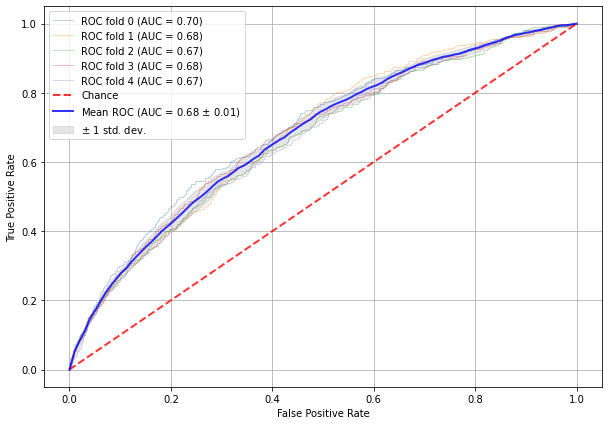

In [833]:
mean_auc = score_and_plot_model(lr_l1_ranked, X_train[ranked_feature_names[:50]], y_train)[0]

Again the AUC has not increased significantly

In [834]:
AUC_dict['LR + L1 + top 50 ranking'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019,
 'LR + L1': 0.6725085508655976,
 'LR + L1 + balanced': 0.6691666746294899,
 'LR + L1 + balanced + top 50 ranking': 0.686717722681359,
 'LR + L2 + balanced + RFE subset': 0.7034887052341596,
 'LR + L2 + balanced + adaboost ensemble': 0.7020315886134068,
 'DT base': 0.5334932559175184,
 'DT + balanced + adaboosted ensemble': 0.708002567571154,
 'LR + L1 + top 50 ranking': 0.678423480695752,
 'LR + L2 + RFE subset': 0.6860923936507053,
 'LR + L2 + bagged ensemble': 0.6716250732217784,
 'DT + balanced + bagged ensemble': 0.6821332857519046,
 'DT + balanced + random forest ensemble': 0.70309697918291,
 'DT + balanced + random forest shallow ensemble': 0.6899848629144493,
 'DT + balanced + extra tress shallow ensemble': 0.655332799196807,
 'DT + balanced + gradient boosted ensemble': 0.6840349931814101,
 'DT + balanced + adaboosted ensemble & DT + balanced + random forest ensemble': 0.6977239741880985}

## Further feature selection + L2 Regularisation
Let me try a more rigorous feature selection using recursive feature elimination (wrapper feature selection technique) with cross validation followed by a LR model with an L2 penalty and balanced classes. I use L2 since this more indepth feature selection will already have selected the most useful features and so I do not need to shrink the coefficient of the features down to exactly zero.

I will use ROC AUC to determine the best subset of features.

In [750]:
from sklearn.feature_selection import RFECV

In [751]:
lr_l2_cv = LogisticRegression(penalty='l2', solver='liblinear')

In [753]:
selector = RFECV(lr_l2_cv, cv=3, scoring='roc_auc', step=1,  verbose=2, n_jobs=-1)

**WARNING: This takes a long time. Also your computer will sound like its getting ready for lift off**

In [754]:
selector.fit(X_train, y_train)

Fitting estimator with 242 features.
Fitting estimator with 241 features.
Fitting estimator with 240 features.
Fitting estimator with 239 features.
Fitting estimator with 238 features.
Fitting estimator with 237 features.
Fitting estimator with 236 features.
Fitting estimator with 235 features.
Fitting estimator with 234 features.
Fitting estimator with 233 features.
Fitting estimator with 232 features.
Fitting estimator with 231 features.
Fitting estimator with 230 features.
Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
F

RFECV(cv=3,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='liblinear', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='roc_auc', step=1,
      verbose=2)

The recursive feature elimination has chosen a model with 22 features as having the best cross-validated AUC.

In [756]:
selector.n_features_

22

In [757]:
best_lr = selector.estimator_

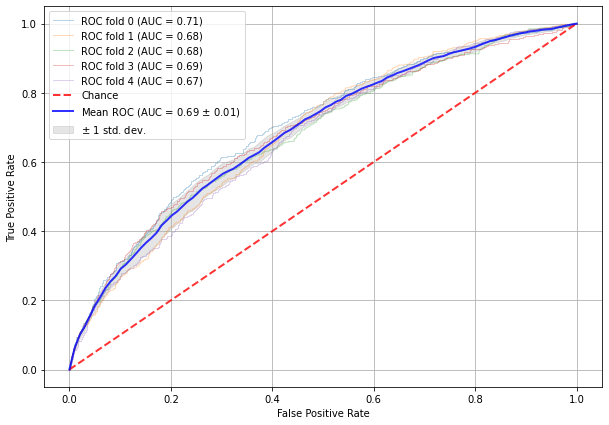

In [835]:
mean_auc = score_and_plot_model(best_lr, X_train.loc[:, selector.support_], y_train)[0]

Choosing the best subset using RFE has yielded a very small increase in AUC to 0.69. What's is interesting is that in one fold the CV AUC is as 0.71 and in another it is 0.67 suggesting there is a fair amount of variance in the model at the moment.

Because of this I think I have reached the limit with what is possible with single LR models. I will now move on to ensemble methods to attempt to address the high variance.

In [836]:
AUC_dict['LR + L2 + RFE subset'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019,
 'LR + L1': 0.6725085508655976,
 'LR + L1 + balanced': 0.6691666746294899,
 'LR + L1 + balanced + top 50 ranking': 0.686717722681359,
 'LR + L2 + balanced + RFE subset': 0.7034887052341596,
 'LR + L2 + balanced + adaboost ensemble': 0.7020315886134068,
 'DT base': 0.5334932559175184,
 'DT + balanced + adaboosted ensemble': 0.708002567571154,
 'LR + L1 + top 50 ranking': 0.678423480695752,
 'LR + L2 + RFE subset': 0.6860923936507053,
 'LR + L2 + bagged ensemble': 0.6716250732217784,
 'DT + balanced + bagged ensemble': 0.6821332857519046,
 'DT + balanced + random forest ensemble': 0.70309697918291,
 'DT + balanced + random forest shallow ensemble': 0.6899848629144493,
 'DT + balanced + extra tress shallow ensemble': 0.655332799196807,
 'DT + balanced + gradient boosted ensemble': 0.6840349931814101,
 'DT + balanced + adaboosted ensemble & DT + balanced + random forest ensemble': 0.6977239741880985}

## Bagged Logistic Regression

The above models are all single models. There seems to be no way to improve the AUC past 0.69 using just a single model. I am going to include all the features again to give the bagged LR models the best chance of extracting some hidden features that may be related to the target. 

In [760]:
from sklearn.ensemble import BaggingClassifier

In [761]:
bc_lr = BaggingClassifier(LogisticRegression(penalty='l2', solver='newton-cg', max_iter=200), n_estimators=100)

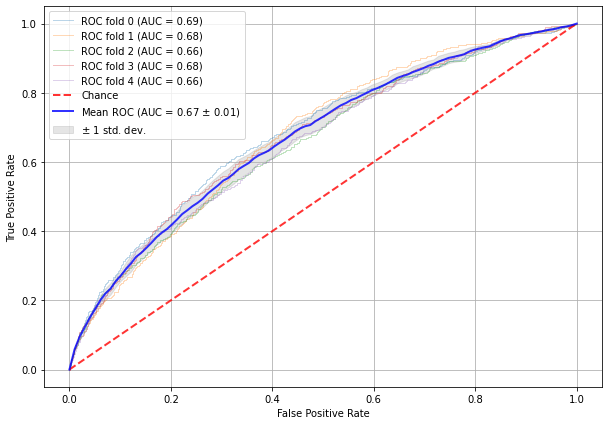

In [839]:
mean_auc = score_and_plot_model(bc_lr, X_train, y_train)[0]

It doesn't look like logistic regression is going to be able to get an AUC better than 0.69 with this dataset. It may be that the imputation methods that I have used have introduced too much noise into the data. But it could also be that the relationship between churners and the features is highly non-linear.

To see if I can capture this possible non-linear relationship I will now move on to Decision Trees.

In [840]:
AUC_dict['LR + L2 + bagged ensemble'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019,
 'LR + L1': 0.6725085508655976,
 'LR + L1 + balanced': 0.6691666746294899,
 'LR + L1 + balanced + top 50 ranking': 0.686717722681359,
 'LR + L2 + balanced + RFE subset': 0.7034887052341596,
 'LR + L2 + balanced + adaboost ensemble': 0.7020315886134068,
 'DT base': 0.5334932559175184,
 'DT + balanced + adaboosted ensemble': 0.708002567571154,
 'LR + L1 + top 50 ranking': 0.678423480695752,
 'LR + L2 + RFE subset': 0.6860923936507053,
 'LR + L2 + bagged ensemble': 0.6719704763611772,
 'DT + balanced + bagged ensemble': 0.6821332857519046,
 'DT + balanced + random forest ensemble': 0.70309697918291,
 'DT + balanced + random forest shallow ensemble': 0.6899848629144493,
 'DT + balanced + extra tress shallow ensemble': 0.655332799196807,
 'DT + balanced + gradient boosted ensemble': 0.6840349931814101,
 'DT + balanced + adaboosted ensemble & DT + balanced + random forest ensemble': 0.6977239741880985}

***
***
# Decision Trees
## Single Decision Tree
As before, I will start off with the base case of a vanilla decision tree fit to all the available features with the imbalanced dataset

In [714]:
from sklearn.tree import DecisionTreeClassifier

In [715]:
dtc = DecisionTreeClassifier(criterion='gini', splitter = 'best')

For this dataset a single decision tree is no better than random.

In [717]:
AUC_dict['DT base'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019,
 'LR + L1': 0.6725085508655976,
 'LR + L1 + balanced': 0.7033979797979797,
 'LR + L1 + balanced + top 50 ranking': 0.686717722681359,
 'LR + L2 + balanced + RFE subset': 0.7034887052341596,
 'LR + L2 + balanced + adaboost ensemble': 0.7020315886134068,
 'DT base': 0.5334932559175184}

## Boosted Decision Tree + balanced data
I will start with a boosted decision tree ensemble with each decision tree being a stump.

In [766]:
from sklearn.ensemble import AdaBoostClassifier

In [767]:
abc_dt = AdaBoostClassifier(DecisionTreeClassifier(criterion='gini', splitter = 'best', max_depth=1), n_estimators=100,
                         learning_rate=0.05)

Here I have been careful to train the models on the training oversampled dataset but then to evaluate them on the original dataset.

*NOTE: Since adadelta boosting gives more weights to incorrectly classified examples for the next tree that is fit, it may not be necessary to use re-sampled data. I am not sure though so I am going to use re-sampled data anyway.

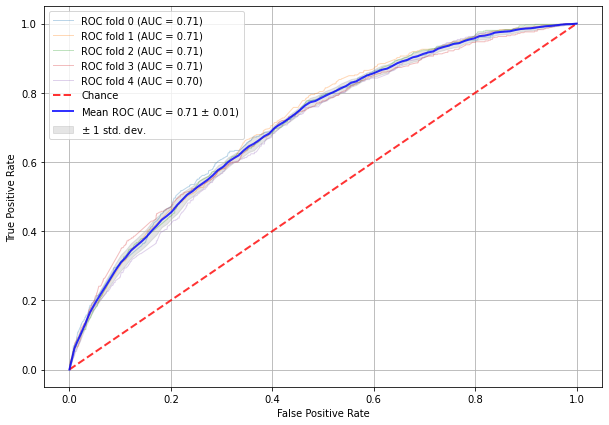

In [769]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

ros = RandomOverSampler()

fig, ax = plt.subplots(figsize=(10,7))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    
    # Get training fold
    X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
    
    # Get validation fold
    X_val_fold, y_val_fold = X_train.iloc[test], y_train.iloc[test]
    
    # Over-sample data from training fold
    X_train_fold_resample, y_train_fold_resample = ros.fit_resample(X_train_fold, y_train_fold)
    
    # Fit model using the resampled training fold
    abc_dt.fit(X_train_fold_resample, y_train_fold_resample)
    
    # Evaluate AUC using non-sampled validation fold
    viz = plot_roc_curve(abc_dt, X_val_fold,
                         y_val_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.legend()
plt.grid(which='both')
plt.show()

This is the best model so far. It has achieve an AUC of 0.71 and within the error bars it could be as high as 0.72. The vairance between models is still 0.01 so I shall now try to use a bagged forest which helps to reduce variance by combining the predictions of many trees each trained on a different subset of the data.

In [770]:
AUC_dict['DT + balanced + adaboosted ensemble'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019,
 'LR + L1': 0.6725085508655976,
 'LR + L1 + balanced': 0.6691666746294899,
 'LR + L1 + balanced + top 50 ranking': 0.686717722681359,
 'LR + L2 + balanced + RFE subset': 0.7034887052341596,
 'LR + L2 + balanced + adaboost ensemble': 0.7020315886134068,
 'DT base': 0.5334932559175184,
 'DT + balanced + adaboosted ensemble': 0.708002567571154,
 'LR + L1 + top 50 ranking': 0.6767492126698263,
 'LR + L2 + RFE subset': 0.6860923936507053,
 'LR + L2 + bagged ensemble': 0.6716250732217784}

## Bagged Decision Tree
Here I am using a combination of 200 decision tree each trained on a bootstrapped sample of the oversampled dataset

In [774]:
from sklearn.ensemble import BaggingClassifier

In [775]:
bc_dt = BaggingClassifier(DecisionTreeClassifier(criterion='gini', splitter='best'), n_estimators=200)

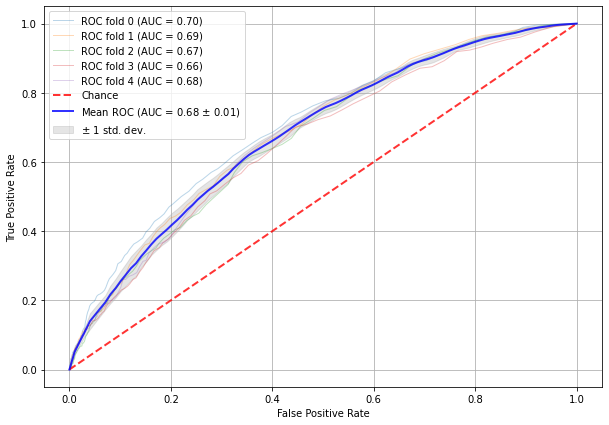

In [776]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

ros = RandomOverSampler()

fig, ax = plt.subplots(figsize=(10,7))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    
    # Get training fold
    X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
    
    # Get validation fold
    X_val_fold, y_val_fold = X_train.iloc[test], y_train.iloc[test]
    
    # Over-sample data from training fold
    X_train_fold_resample, y_train_fold_resample = ros.fit_resample(X_train_fold, y_train_fold)
    
    # Fit model using the resampled training fold
    bc_dt.fit(X_train_fold_resample, y_train_fold_resample)
    
    # Evaluate AUC using non-sampled validation fold
    viz = plot_roc_curve(bc_dt, X_val_fold,
                         y_val_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.legend()
plt.grid(which='both')
plt.show()

This has not improved the performance compared to the boosted decision tree model suggesting variance is not an issue here. 

However, I will try a random forest just to see what happens.

In [777]:
AUC_dict['DT + balanced + bagged ensemble'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019,
 'LR + L1': 0.6725085508655976,
 'LR + L1 + balanced': 0.6691666746294899,
 'LR + L1 + balanced + top 50 ranking': 0.686717722681359,
 'LR + L2 + balanced + RFE subset': 0.7034887052341596,
 'LR + L2 + balanced + adaboost ensemble': 0.7020315886134068,
 'DT base': 0.5334932559175184,
 'DT + balanced + adaboosted ensemble': 0.708002567571154,
 'LR + L1 + top 50 ranking': 0.6767492126698263,
 'LR + L2 + RFE subset': 0.6860923936507053,
 'LR + L2 + bagged ensemble': 0.6716250732217784,
 'DT + balanced + bagged ensemble': 0.6821332857519046}

## Random Forest 
Here I try using a random forest which is essentially the same as a bagged ensemble of decision trees except that random forest try to decrease variance by selecting a random subset of the features to consider for split candidates at each node of the trees as well as using bootstrapped datasets for each tree.

I also tyr using entropy as the scoring metric when evaluating possible split points instead of the gini coefficient

In [778]:
from sklearn.ensemble import RandomForestClassifier

In [781]:
rfc = RandomForestClassifier(criterion='entropy', n_estimators=400)

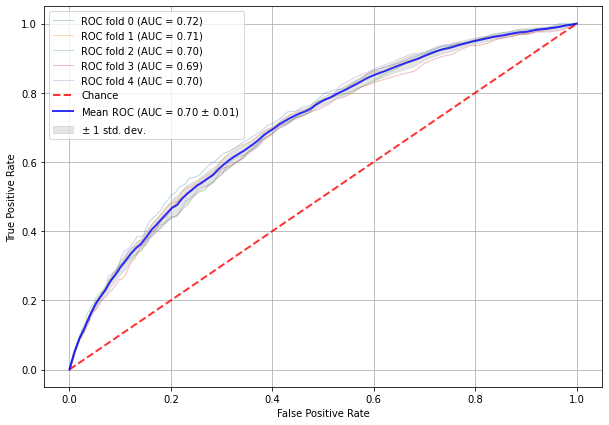

In [782]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

ros = RandomOverSampler()

fig, ax = plt.subplots(figsize=(10,7))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    
    # Get training fold
    X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
    
    # Get validation fold
    X_val_fold, y_val_fold = X_train.iloc[test], y_train.iloc[test]
    
    # Over-sample data from training fold
    X_train_fold_resample, y_train_fold_resample = ros.fit_resample(X_train_fold, y_train_fold)
    
    # Fit model using the resampled training fold
    rfc.fit(X_train_fold_resample, y_train_fold_resample)
    
    # Evaluate AUC using non-sampled validation fold
    viz = plot_roc_curve(rfc, X_val_fold,
                         y_val_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.legend()
plt.grid(which='both')
plt.show()

Surprisingly, even though I thought variance was not an issue this has achieved an average AUC of 0.7. Furthermore, the highest scoring fold achieved an AUC of 0.72 and the lowest 0.69 which suggests that even with 400 trees variance is still an issue. This is most likely because each tree is overfitting as I have not set a max_depth parameter. If you do not set this the nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split (which is 2 by default) samples.

The average tree depth of the random forest is 48 so I will set max_depth to a value less than this.

In [790]:
AUC_dict['DT + balanced + random forest ensemble'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019,
 'LR + L1': 0.6725085508655976,
 'LR + L1 + balanced': 0.6691666746294899,
 'LR + L1 + balanced + top 50 ranking': 0.686717722681359,
 'LR + L2 + balanced + RFE subset': 0.7034887052341596,
 'LR + L2 + balanced + adaboost ensemble': 0.7020315886134068,
 'DT base': 0.5334932559175184,
 'DT + balanced + adaboosted ensemble': 0.708002567571154,
 'LR + L1 + top 50 ranking': 0.6767492126698263,
 'LR + L2 + RFE subset': 0.6860923936507053,
 'LR + L2 + bagged ensemble': 0.6716250732217784,
 'DT + balanced + bagged ensemble': 0.6821332857519046,
 'DT + balanced + random forest ensemble': 0.70309697918291}

In [801]:
summation = 0
for tree in rfc.estimators_:
    summation += tree.tree_.max_depth
summation/400

47.785

## Shallow Random forest
As seen above, the random forest managed to achieve a AUC of 0.7 but the CV folds displayed some variance. This most likely due to overfitting the data because I did not set max_depth. So I will repeat the same as I did above but for a shallower random forest

In [803]:
rfc_shallow = RandomForestClassifier(criterion='entropy', n_estimators=500, max_depth=20)

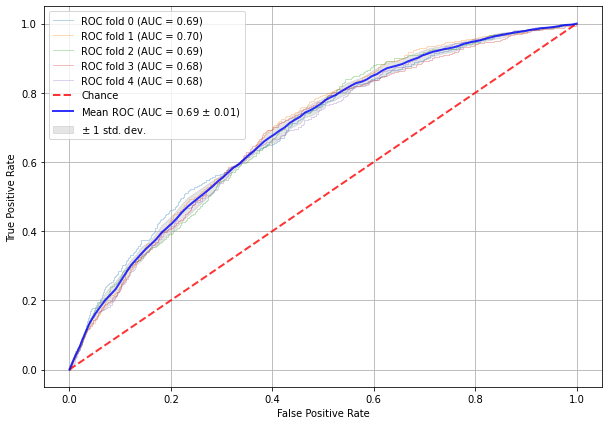

In [804]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

ros = RandomOverSampler()

fig, ax = plt.subplots(figsize=(10,7))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    
    # Get training fold
    X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
    
    # Get validation fold
    X_val_fold, y_val_fold = X_train.iloc[test], y_train.iloc[test]
    
    # Over-sample data from training fold
    X_train_fold_resample, y_train_fold_resample = ros.fit_resample(X_train_fold, y_train_fold)
    
    # Fit model using the resampled training fold
    rfc_shallow.fit(X_train_fold_resample, y_train_fold_resample)
    
    # Evaluate AUC using non-sampled validation fold
    viz = plot_roc_curve(rfc_shallow, X_val_fold,
                         y_val_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.legend()
plt.grid(which='both')
plt.show()

Making the forest shallower has not helped to increase the AUC or reduce the variance.

I can really try to push variance lower by using a extra trees classifier

In [805]:
AUC_dict['DT + balanced + random forest shallow ensemble'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019,
 'LR + L1': 0.6725085508655976,
 'LR + L1 + balanced': 0.6691666746294899,
 'LR + L1 + balanced + top 50 ranking': 0.686717722681359,
 'LR + L2 + balanced + RFE subset': 0.7034887052341596,
 'LR + L2 + balanced + adaboost ensemble': 0.7020315886134068,
 'DT base': 0.5334932559175184,
 'DT + balanced + adaboosted ensemble': 0.708002567571154,
 'LR + L1 + top 50 ranking': 0.6767492126698263,
 'LR + L2 + RFE subset': 0.6860923936507053,
 'LR + L2 + bagged ensemble': 0.6716250732217784,
 'DT + balanced + bagged ensemble': 0.6821332857519046,
 'DT + balanced + random forest ensemble': 0.70309697918291,
 'DT + balanced + random forest shallow ensemble': 0.6899848629144493}

## Extra Tree Classifier
Now I go for the most variance reduced model possible which is an extra tree classifier

In [807]:
from sklearn.ensemble import ExtraTreesClassifier

In [810]:
etc = ExtraTreesClassifier(criterion='entropy', n_estimators=400, max_depth=20)

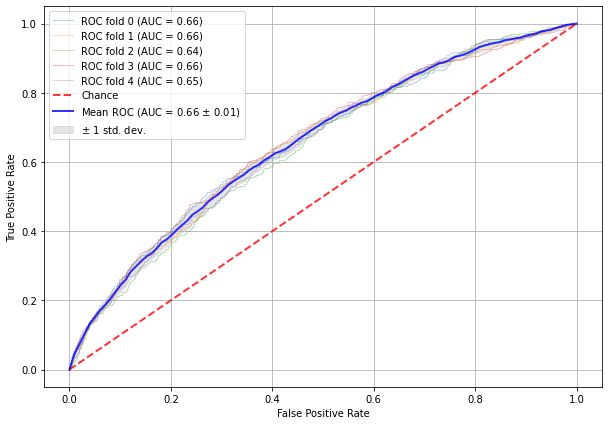

In [811]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

ros = RandomOverSampler()

fig, ax = plt.subplots(figsize=(10,7))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    
    # Get training fold
    X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
    
    # Get validation fold
    X_val_fold, y_val_fold = X_train.iloc[test], y_train.iloc[test]
    
    # Over-sample data from training fold
    X_train_fold_resample, y_train_fold_resample = ros.fit_resample(X_train_fold, y_train_fold)
    
    # Fit model using the resampled training fold
    etc.fit(X_train_fold_resample, y_train_fold_resample)
    
    # Evaluate AUC using non-sampled validation fold
    viz = plot_roc_curve(etc, X_val_fold,
                         y_val_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.legend()
plt.grid(which='both')
plt.show()

Using a ensemble of extra trees has not helped in increasing the AUC.

In [814]:
AUC_dict['DT + balanced + extra tress shallow ensemble'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019,
 'LR + L1': 0.6725085508655976,
 'LR + L1 + balanced': 0.6691666746294899,
 'LR + L1 + balanced + top 50 ranking': 0.686717722681359,
 'LR + L2 + balanced + RFE subset': 0.7034887052341596,
 'LR + L2 + balanced + adaboost ensemble': 0.7020315886134068,
 'DT base': 0.5334932559175184,
 'DT + balanced + adaboosted ensemble': 0.708002567571154,
 'LR + L1 + top 50 ranking': 0.6767492126698263,
 'LR + L2 + RFE subset': 0.6860923936507053,
 'LR + L2 + bagged ensemble': 0.6716250732217784,
 'DT + balanced + bagged ensemble': 0.6821332857519046,
 'DT + balanced + random forest ensemble': 0.70309697918291,
 'DT + balanced + random forest shallow ensemble': 0.6899848629144493,
 'DT + balanced + extra tress shallow ensemble': 0.655332799196807}

## Gradient Boosted Decision Tree
Since the best model so far used a adadelta boosted decision tree I will now see if I can improve on the AUC score by using a gradient boosted decision tree

In [815]:
from sklearn.ensemble import GradientBoostingClassifier

In [819]:
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.01, n_estimators=500, max_depth=10)

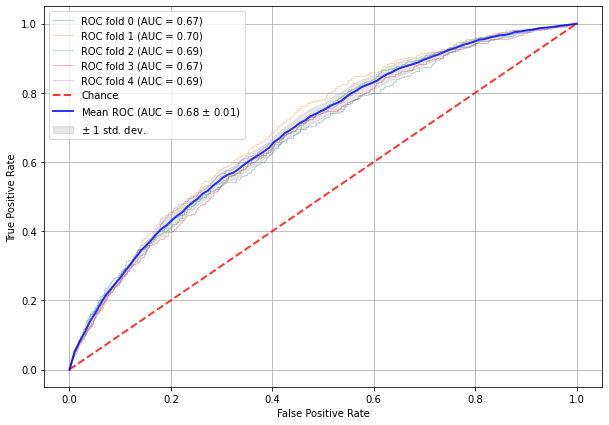

In [820]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

ros = RandomOverSampler()

fig, ax = plt.subplots(figsize=(10,7))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    
    # Get training fold
    X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
    
    # Get validation fold
    X_val_fold, y_val_fold = X_train.iloc[test], y_train.iloc[test]
    
    # Over-sample data from training fold
    X_train_fold_resample, y_train_fold_resample = ros.fit_resample(X_train_fold, y_train_fold)
    
    # Fit model using the resampled training fold
    gbc.fit(X_train_fold_resample, y_train_fold_resample)
    
    # Evaluate AUC using non-sampled validation fold
    viz = plot_roc_curve(gbc, X_val_fold,
                         y_val_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.legend()
plt.grid(which='both')
plt.show()

Again no improvement over the model using a adadelta boosted decision tree ensemble

In [821]:
AUC_dict['DT + balanced + gradient boosted ensemble'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019,
 'LR + L1': 0.6725085508655976,
 'LR + L1 + balanced': 0.6691666746294899,
 'LR + L1 + balanced + top 50 ranking': 0.686717722681359,
 'LR + L2 + balanced + RFE subset': 0.7034887052341596,
 'LR + L2 + balanced + adaboost ensemble': 0.7020315886134068,
 'DT base': 0.5334932559175184,
 'DT + balanced + adaboosted ensemble': 0.708002567571154,
 'LR + L1 + top 50 ranking': 0.6767492126698263,
 'LR + L2 + RFE subset': 0.6860923936507053,
 'LR + L2 + bagged ensemble': 0.6716250732217784,
 'DT + balanced + bagged ensemble': 0.6821332857519046,
 'DT + balanced + random forest ensemble': 0.70309697918291,
 'DT + balanced + random forest shallow ensemble': 0.6899848629144493,
 'DT + balanced + extra tress shallow ensemble': 0.655332799196807,
 'DT + balanced + gradient boosted ensemble': 0.6840349931814101}

## Ensemble of Ensembles - Adaboosted LR and random forest
Here I am going to try constructing an ensemble of the best methods that i have tried so far and see if the combined predictive power of these together is better than each of them alone.

First I will try try the adadelta boosted decision tree ensemble and the random forest together

In [812]:
from sklearn.ensemble import VotingClassifier

In [813]:
AUC_dict

{'LR base': 0.6714931220029019,
 'LR + L1': 0.6725085508655976,
 'LR + L1 + balanced': 0.6691666746294899,
 'LR + L1 + balanced + top 50 ranking': 0.686717722681359,
 'LR + L2 + balanced + RFE subset': 0.7034887052341596,
 'LR + L2 + balanced + adaboost ensemble': 0.7020315886134068,
 'DT base': 0.5334932559175184,
 'DT + balanced + adaboosted ensemble': 0.708002567571154,
 'LR + L1 + top 50 ranking': 0.6767492126698263,
 'LR + L2 + RFE subset': 0.6860923936507053,
 'LR + L2 + bagged ensemble': 0.6716250732217784,
 'DT + balanced + bagged ensemble': 0.6821332857519046,
 'DT + balanced + random forest ensemble': 0.70309697918291,
 'DT + balanced + random forest shallow ensemble': 0.6899848629144493}

In [823]:
vc = VotingClassifier(estimators=[('abc_dt', abc_dt), ('rf', rfc)], voting='soft', n_jobs=-1)

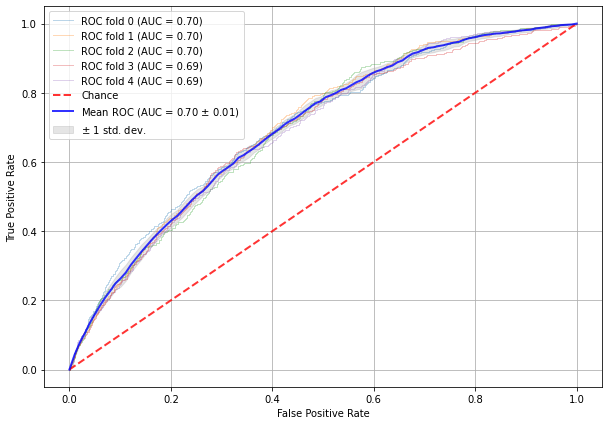

In [824]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

ros = RandomOverSampler()

fig, ax = plt.subplots(figsize=(10,7))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    
    # Get training fold
    X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
    
    # Get validation fold
    X_val_fold, y_val_fold = X_train.iloc[test], y_train.iloc[test]
    
    # Over-sample data from training fold
    X_train_fold_resample, y_train_fold_resample = ros.fit_resample(X_train_fold, y_train_fold)
    
    # Fit model using the resampled training fold
    vc.fit(X_train_fold_resample, y_train_fold_resample)
    
    # Evaluate AUC using non-sampled validation fold
    viz = plot_roc_curve(vc, X_val_fold,
                         y_val_fold,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

plt.legend()
plt.grid(which='both')
plt.show()

The AUC is actually slightly reduced using both of these together. This must mean that they disagree on some observations which individually they would correctly classify.

In [825]:
AUC_dict['DT + balanced + adaboosted ensemble & DT + balanced + random forest ensemble'] = mean_auc
AUC_dict

{'LR base': 0.6714931220029019,
 'LR + L1': 0.6725085508655976,
 'LR + L1 + balanced': 0.6691666746294899,
 'LR + L1 + balanced + top 50 ranking': 0.686717722681359,
 'LR + L2 + balanced + RFE subset': 0.7034887052341596,
 'LR + L2 + balanced + adaboost ensemble': 0.7020315886134068,
 'DT base': 0.5334932559175184,
 'DT + balanced + adaboosted ensemble': 0.708002567571154,
 'LR + L1 + top 50 ranking': 0.6767492126698263,
 'LR + L2 + RFE subset': 0.6860923936507053,
 'LR + L2 + bagged ensemble': 0.6716250732217784,
 'DT + balanced + bagged ensemble': 0.6821332857519046,
 'DT + balanced + random forest ensemble': 0.70309697918291,
 'DT + balanced + random forest shallow ensemble': 0.6899848629144493,
 'DT + balanced + extra tress shallow ensemble': 0.655332799196807,
 'DT + balanced + gradient boosted ensemble': 0.6840349931814101,
 'DT + balanced + adaboosted ensemble & DT + balanced + random forest ensemble': 0.6977239741880985}

***
***
# Support Vector Machines
The final method I am going to try to use is a SVM. If this data is non-linear than an SVM using the kernel trick may be able to accurately capture this behaviour and separate the two classes. However it does this by projecting the observations into a space with higher dimensions than its current dimension. Because of this I would be surprised if an SVM performs well on this high dimensional and spare dataset but let's see anyway